
# Generate surface currents

Load all necessary modules

In [73]:
using CoastalCurrents
using CoastalCurrents: Altimetry
using DIVAnd_HFRadar
using PhysOcean
using GeoMapping
using PyPlot
using NCDatasets
using Dates
using Test
using DIVAnd
using DataStructures
using Statistics

In [74]:
include("common.jl")

Load the data generated by `prep_altimetry` notebook/script. All variables are vectors (list of tracks) of vectors (individual tracks). We are not using a matrix
since each tracks can have a different length.

* `mdt`: mean dynamic topography
* `sla`: sea-level anomalies
* `lon`,`lat`,`time`: longitude,latitude and time
* `id`: identifier of the track

In [75]:
ds = NCDataset(altimetry_fname)
mdt = NCDatasets.loadragged(ds["mdt"],:)
sla = NCDatasets.loadragged(ds["slaf"],:)
lon = NCDatasets.loadragged(ds["lon"],:)
lat = NCDatasets.loadragged(ds["lat"],:)
time = NCDatasets.loadragged(ds["time"],:)
id = NCDatasets.loadragged(ds["id"],:)
close(ds);

Time range covered by the data

In [76]:
extrema(reduce(vcat,time))

(DateTime("1992-10-03T07:53:03.377"), DateTime("2022-08-04T22:03:37.120"))

Number of tracks

In [77]:
length(lon)

136259

Average length of each track

In [78]:
mean(length.(lon))

98.2789980845302

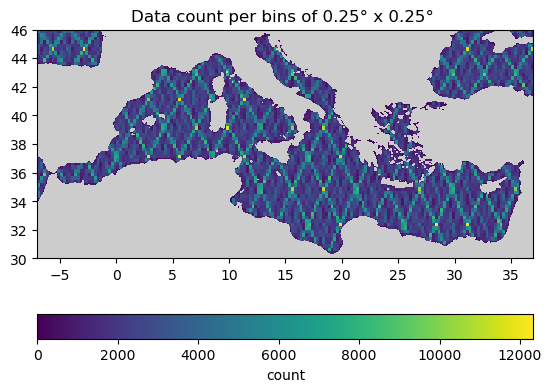

In [79]:
plt.hist2d(reduce(vcat,lon),reduce(vcat,lat),(lonr,latr))
colorbar(orientation="horizontal",label="count")
CoastalCurrents.Plotting.plotmap(bathname)
title("Data count per bins of $(step(lonr))° x $(step(latr))° ");

Compute absolute dynamic topography (`adt`)

In [80]:
adt = mdt .+ sla;

Compute geostrophic velocity

In [81]:
(lona_,lata_,timea_,ua_,va_) = Altimetry.geostrophic_velocity(lon,lat,time,adt);

Plot a couple of tracks to verify the orientation of the velocity

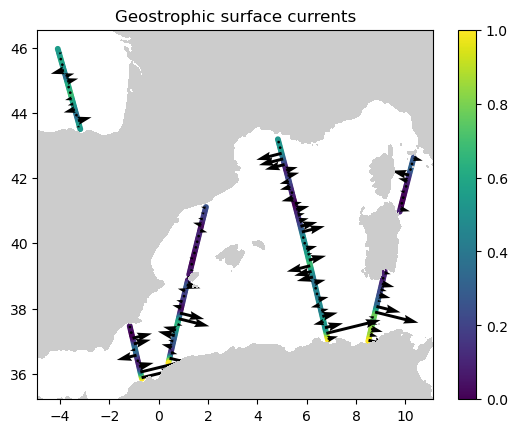

PyObject Text(0.5, 1.0, 'Geostrophic surface currents')

In [82]:
clf()
scale = 5
for i = [2 4 6 8]
    scatter(lon[i],lat[i],10,adt[i]);
    r = 1:3:length(lona_[i])
    quiver(lona_[i][r],lata_[i][r],ua_[i][r],va_[i][r],scale=scale,lw = 0.1)
end
colorbar()
CoastalCurrents.Plotting.plotmap(bathname)
title("Geostrophic surface currents")

Concatenate the data into a single vector

In [83]:
lona = reduce(vcat,lona_);
lata = reduce(vcat,lata_);
timea = reduce(vcat,timea_);
ua = reduce(vcat,ua_);
va = reduce(vcat,va_);

Select the data to be used
Here we use all data of the year 2000
To select all the data of the month january for example one would use
```julia
 sel = @. Dates.Month(timea) == 1
```

In [84]:
sel = @. Dates.DateTime(2000,1,1) <= timea < Dates.DateTime(2001,1,1);
lona = lona[sel];
lata = lata[sel];
timea = timea[sel];
ua = ua[sel];
va = va[sel];

Compute current speed `robs` and direction `directionobs`.
`directionobs` is the angle in degree relative to North counted clock-wise
see DIVAndrun_HFRadar

In [85]:
robs = sqrt.(ua.^2 + va.^2)
directionobs = atand.(ua,va);

Set-up the domain

In [86]:
mask,(pm,pn),(xi,yi) = DIVAnd.domain(bathname,bathisglobal,lonr,latr)
mask = DIVAnd.floodfill(mask) .== 1
hx, hy, h = DIVAnd.load_bath(bathname, bathisglobal, lonr, latr);

Ignore data which are NaN

In [87]:
valid = isfinite.(robs);
x = lona[valid];
y = lata[valid];
robs = robs[valid];
directionobs = directionobs[valid];

Choose analysis parameters

In [88]:
len = 150e3
epsilon2 = 2.
eps2_boundary_constraint = -1
eps2_div_constraint = 1
g = 0;

Make the DIVAnd analysis

In [95]:
uri,vri,ηi = DIVAndrun_HFRadar(
    mask,h,(pm,pn),(xi,yi),(x,y),robs,directionobs,len,epsilon2;
    eps2_boundary_constraint = eps2_boundary_constraint,
    eps2_div_constraint = eps2_div_constraint,
    # eps2_Coriolis_constraint = -1,
    # f = 0.001,
    # residual = residual,
    # g = g,
    # ratio = 100,
    # lenη = (000.0, 000.0, 24 * 60 * 60. * 10),
    # maxit = 100000,
    # tol = 1e-6,
);

Save the results

In [101]:
timei = timea[1:1]
CoastalCurrents.save(
    result_filename,
    (xi[:,1],yi[1,:],timei[1:1]),
    (uri[:,:,1:1],vri[:,:,1:1]))

Plot results

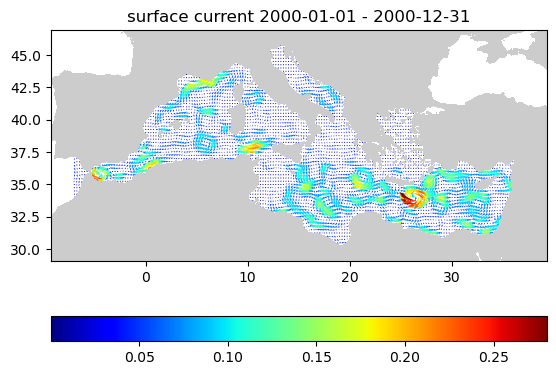

In [102]:
color = sqrt.(uri.^2 + vri.^2)
clf()
r = CartesianIndices(( 1:2:size(mask,1) ,1:2:size(mask,2)))
r = CartesianIndices(( 1:1:size(mask,1) ,1:1:size(mask,2)))
quiver(xi[r],yi[r],uri[r],vri[r],color[r],cmap="jet")
colorbar(orientation="horizontal")
CoastalCurrents.Plotting.plotmap(bathname)
title("surface current " * join(Dates.format.((minimum(timea),maximum(timea)),"yyyy-mm-dd")," - "));

Visalize with the leaflet javascript library 🍃

In [103]:
CoastalCurrents.Plotting.plot(xi,yi,uri,vri,scale = 15,maxvelocity = 0.05);